In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [5]:
data_23 = pd.read_csv("raw_counts.23.csv", index_col=0)

In [6]:
data_104 = pd.read_csv("raw_counts.104.csv", index_col=0)

In [7]:
responses = pd.read_csv('../responses.127.txt', sep="\t", index_col=0)

In [8]:
data_104.columns = data_104.columns.str.replace('[ABC]','',regex=True)

In [9]:
data_104.drop(columns=['Gene.name'], inplace=True)

In [10]:
data = pd.concat([data_104, data_23], axis=1)

In [11]:
data = data.reindex(sorted(data.columns), axis=1)

In [23]:
data_norm = data.iloc[:,1:] / data.iloc[:,1:].quantile(q=0.80)*100

In [24]:
data_norm = data_norm + 1

In [25]:
data_norm = np.log2(data_norm)

In [26]:
data_norm['Gene.name'] = data['Gene.name']

In [27]:
data_norm = data_norm.reindex(sorted(data_norm.columns), axis=1)

In [29]:
def t_test(row):
    low_group = row[1:][list(responses.iloc[:,0] == 'Low')].astype('float')
    high_group = row[1:][list(responses.iloc[:,0] == 'High')].astype('float')
    print(low_group.mean())
    print(high_group.mean())
    row['fold_change'] = high_group.mean() - low_group.mean()
    row['pvalue_ttest'] = ttest_ind(low_group, high_group).pvalue
    return row

In [30]:
data_norm = data_norm.apply(t_test, axis=1)

0.3654872787260906
0.21570330403649196
7.77879916541458
7.82901344653834
2.983054977107619
3.1508298579579312
0.47887678544083506
0.5614137336935499
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.28565243019636666
0.5391821042840828
0.0
0.0
0.6838442920828258
0.9131119226011002
4.500739958028621
4.560118932588959
4.6261840581327425
4.819013652056663
1.048606741896037
0.6455401150297853
3.5443389722320267
3.2202678456532654
0.2099365867691622
0.1173032262091371
0.0
0.09029401064439573
0.6259038319659765
0.6880325115997645
7.930552385681513
8.043229390178336
0.26908072073422956
0.43292200832991784
2.5703491173927087
2.450221388135682
0.0
0.0
0.1672510276878509
0.1095398197034176
0.0
0.03500448851379327
0.03627912147705231
0.0
4.186115580430853
3.8246673587706312
0.0
0.0339388001154521
0.0
0.0
0.0
0.0
0.0
0.19354848871298364
1.212432747082456
0.6690944154513266
0.2339992611711961
0.1446269039938833
0.8990802059590548
1.1026820788137335
0.06829200279080477
0.0
3.6572734862670457
3.438216748842889
8.476

In [19]:
data_norm.sort_values('pvalue_ttest', inplace=True)

In [25]:
data_norm = data_norm.rename(columns={'fold_change': 'log2 fold_change'})

In [43]:
data_norm.dropna(subset=['pvalue_ttest'],inplace=True)

In [44]:
adj = multipletests(data_norm['pvalue_ttest'], method='bonferroni')
data_norm['pvalue_BF_adjusted'] = adj[1]

In [45]:
adj = multipletests(data_norm['pvalue_ttest'], method='fdr_bh')

In [47]:
data_norm['pvalue_FDR_adjusted'] = adj[1]

In [48]:
data_norm.columns

Index(['Gene.name', 'log2 fold_change', 'pvalue_ttest', 'pvalue_BF_adjusted',
       'pvalue_FDR_adjusted', 'HMN831856', 'HMN831857', 'HMN831858',
       'HMN832959', 'HMN832960',
       ...
       'LS1173998', 'LS2424746', 'LS2424747', 'LS2425173', 'LS2425336',
       'LS2425343', 'LS8847606', 'LS8847607', 'LS8847675', 'LS8847676'],
      dtype='object', length=132)

In [49]:
#new_index = ['Gene.name', 'log2 fold_change', 'pvalue_ttest', 'pvalue_BF_adjusted', 'pvalue_FDR_adjusted'] + list(data_norm.columns[1:128])
#data_norm = data_norm.reindex(new_index, axis=1)

In [1]:
data_norm.to_csv("differential_GE_2.output.txt",sep="\t")

NameError: name 'data_norm' is not defined

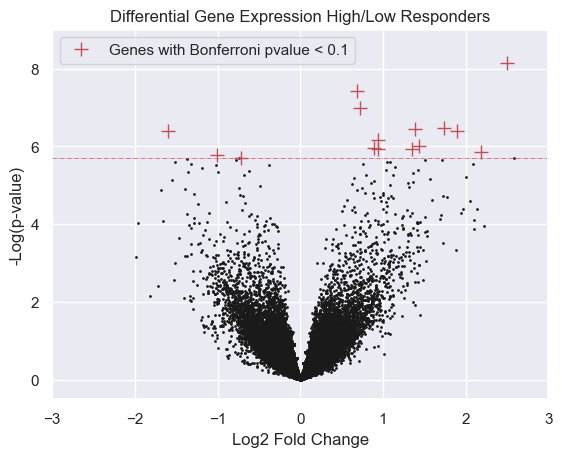

In [76]:
plt.plot(data_norm.loc[data_norm['pvalue_BF_adjusted'] >= 0.1,'log2 fold_change'], -np.log10(data_norm.loc[data_norm['pvalue_BF_adjusted'] >= 0.1,'pvalue_ttest']), 'o', color='k', markersize=1)
plt.plot(data_norm.loc[data_norm['pvalue_BF_adjusted'] < 0.1,'log2 fold_change'], -np.log10(data_norm.loc[data_norm['pvalue_BF_adjusted'] < 0.1,'pvalue_ttest']), '+', color='r', markersize=10, label="Genes with Bonferroni pvalue < 0.1")
plt.legend()
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log(p-value)")
plt.xlim(-3,3)
plt.ylim(-0.5,9)
plt.axhline(y=-np.log10(1.96e-06), color='r', linestyle='-.',lw=0.5)
plt.title("Differential Gene Expression High/Low Responders");